# Notebook to make Fig. 13

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json
import arviz as az

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

style.use('plotting.mplstyle')

import sys
sys.path.append('./../Code/PopulationInference')
from fig_helper_functions import *
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

In [3]:
# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)
chieff_grid =  np.linspace(-1,1,500)
chip_grid =  np.linspace(0,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

In [4]:
# For loading files
pops = ['1', '2', '3']
nevents = ['070', '300'] 

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        
        print(pop, nevent)
        
        numpyro_dir = "../Code/PopulationInference/numpyro/output/"
        name = numpyro_dir+"pop{0}_{1}_events_fitMasses.cdf".format(pop,nevent)
        
        data = az.from_netcdf(name)
        samps = data.posterior.stack(draws=("chain", "draw"))
            
        data_pop[nevent+' events'] = samps    
            
    data_dict['pop '+pop] = data_pop

1 070
1 300
2 070
2 300
3 070
3 300


In [5]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations and numbers of events
for pop in pops: 
    
    pop_key = 'pop '+pop
    traces_pop = {}

    print(pop_key)
    
    for nevent in nevents: 
                    
        # Fetch data
        nevent_key = nevent+' events'
        data = data_dict[pop_key][nevent_key]
        
        # Instantiate an array to hold a collection of traces
        nTraces = min(nTracesMax, len(data['mu_chi'].values))
        p_chi = np.zeros((nTraces,chi_grid.size))
        p_cost = np.zeros((nTraces,cost_grid.size))
        p_chieff = np.zeros((nTraces,chieff_grid.size))
        p_chip = np.zeros((nTraces,chip_grid.size))

        # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
        random_indices = np.random.choice(np.arange(len(data['mu_chi'].values)), size=nTraces,replace=False)
        for i,ind in enumerate(random_indices):
            
            print(i, end='\r')

            mu_chi = np.array(data['mu_chi'].values)[ind]
            sigma_chi = np.array(data['sig_chi'].values)[ind]
            mu1_cost = np.array(data['mu_cost_high'])[ind]
            sigma1_cost = np.array(data['sig_cost_high'])[ind]
            mu2_cost = np.array(data['mu_cost_low'])[ind]
            sigma2_cost = np.array(data['sig_cost_low'])[ind]
            MF_cost = np.array(data['f_big'])[ind]
            Bq = np.array(data['bq'])[ind]

            # calculate gaussian distribution for chi
            p_chi[i,:] = calculate_Gaussian_1D(chi_grid, mu_chi, sigma_chi,0,1)

            # and gaussian distribution for cos(theta)
            p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)
            
            # generate corresponding distribution for chi_eff and chi_p
            chi_effs, chi_ps = draw_chiEffs_and_chiPs_gaussDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, 
                                                                      mCut=8, n=500)
            
            chieff_kde = gaussian_kde(chi_effs)
            p_chieff[i,:] = chieff_kde(chieff_grid)
            
            chip_kde = gaussian_kde(chi_ps)
            p_chip[i,:] = chip_kde(chip_grid)
            
        # Add to dict 
        traces_pop[nevent_key] = {'p_chi':p_chi, 'p_cost':p_cost, 'p_chieff':p_chieff, 'p_chip':p_chip} 
        
    traces_dict[pop_key] = traces_pop

pop 1


/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


pop 2
pop 3


In [6]:
# Labels corresponding to each pop
labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpin}}$'+'\n'+r'$\mathrm{\textsc{Precessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpin}}$'+'\n'+r'$\mathrm{\textsc{Aligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '070 events':'C4', 
    '300 events':'#004f7a'
}

label_kws = dict(fontsize=17, zorder=5)

/local/simona.miller/ipykernel_2687787/364268939.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
/local/simona.miller/ipykernel_2687787/364268939.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2][3].set_xticklabels([int(0), 0.5, int(1)])


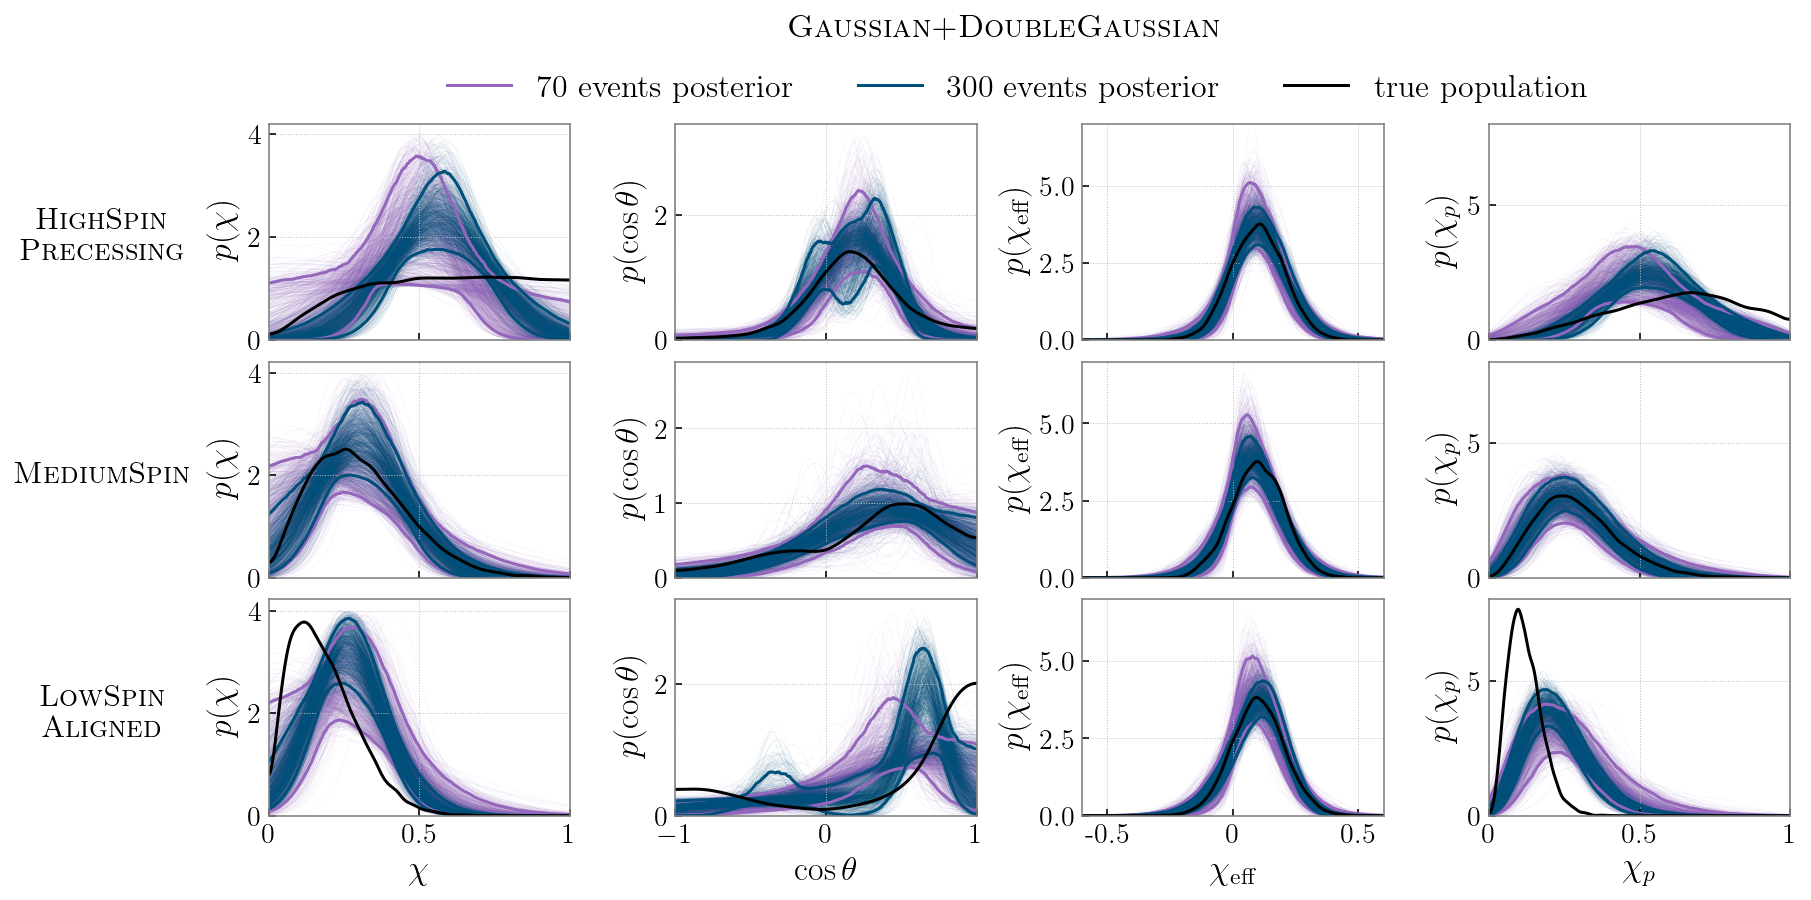

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15/1.1, 7/1.1))

for ax in axes: 
    for a in ax: 
        a.set_rasterization_zorder(2)

for i,pop_key in enumerate(kde_dict):
    for nevent in nevents: 
        nevent_key = nevent+' events'
        
        if nevent[0]=='0':
            label = nevent_key[1:] +' posterior'
        else: 
            label = nevent_key +' posterior'
        
        c = nevents_colors_dict[nevent_key]
        
        ## Plot traces from hyperposteriors + 5% and 95% credible bounds

        # spin magnitude
        p_chi = traces_dict[pop_key][nevent_key]['p_chi']
        axes[i][0].plot(chi_grid, p_chi.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.05,axis=0), color=c, label=label)
        axes[i][0].plot(chi_grid, np.quantile(p_chi,0.95,axis=0), color=c)

        # tilt angle
        p_cost = traces_dict[pop_key][nevent_key]['p_cost']
        axes[i][1].plot(cost_grid, p_cost.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=c)
        axes[i][1].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=c)
        
        # chi effective
        p_chieff = traces_dict[pop_key][nevent_key]['p_chieff']
        axes[i][2].plot(chieff_grid, p_chieff.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.05,axis=0), color=c)
        axes[i][2].plot(chieff_grid, np.quantile(p_chieff,0.95,axis=0), color=c)

        # chi p
        p_chip = traces_dict[pop_key][nevent_key]['p_chip']
        axes[i][3].plot(chip_grid, p_chip.T,color=c, lw=0.15, alpha=0.15, zorder=1)
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.05,axis=0), color=c)
        axes[i][3].plot(chip_grid, np.quantile(p_chip,0.95,axis=0), color=c)

        
    ## Plot injected dists 
    
    # spin magnitude
    axes[i][0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', label='true population')
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,)
    
    # tilt angle
    axes[i][1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k')
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    axes[i][2].plot(chieff_grid, kde_dict[pop_key]['chieff'], color='k')
    axes[i][2].set_xlim(-0.6,0.6)
    axes[i][2].set_ylim(0,11)
    
    # chi p
    axes[i][3].plot(chip_grid, kde_dict[pop_key]['chip'], color='k')
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,11)
    
    
    
    # y-axis labels
    axes[i][0].set_ylabel(r'$p(\chi)$', **label_kws)
    axes[i][1].set_ylabel(r'$p(\cos\theta)$', **label_kws)
    axes[i][2].set_ylabel(r'$p(\chi_\mathrm{eff})$', **label_kws)
    axes[i][3].set_ylabel(r'$p(\chi_p)$', **label_kws)  
    
    # set pop label
    axes[i][0].text(-0.55, 2, labels_dict[pop_key], fontsize=15, 
                    horizontalalignment='center', verticalalignment='center',)
    
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])

# x-axis labels
axes[2][0].set_xlabel(r'$\chi$', **label_kws)
axes[2][1].set_xlabel(r'$\cos\theta$', **label_kws)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', **label_kws)
axes[2][3].set_xlabel(r'$\chi_p$', **label_kws)  

# Set y limits
for a in axes.T[0]:
    a.set_ylim(0, )
for a in axes.T[1]:
    a.set_ylim(0, )
for a in axes.T[2]: 
    a.set_ylim(0,7)
for a in axes.T[3]: 
    a.set_ylim(0,8)

# Add legend
axes[0][0].legend(bbox_to_anchor=(0.55, 1.04, 1., .102), loc='lower left',ncol=3, borderaxespad=0., fontsize=16)
for ax in axes: 
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        
plt.subplots_adjust(hspace=0.1, wspace=0.35)

plt.suptitle(r'$\mathrm{\textsc{Gaussian+DoubleGaussian}}$', fontsize=16, y=1.0)

for ax in axes:
    for a in ax:
        a.spines['bottom'].set_color('gray')
        a.spines['top'].set_color('gray') 
        a.spines['right'].set_color('gray')
        a.spines['left'].set_color('gray')
        
        
axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
axes[2][2].set_xticks([-0.5, int(0), 0.5])
axes[2][2].set_xticklabels([-0.5, int(0), 0.5])
axes[2][3].set_xticklabels([int(0), 0.5, int(1)])

plt.savefig('figure_13.pdf',bbox_inches='tight')
plt.show()